# Anand Mysorekar

## Cogs 118a FA24 Final Project

# Data Preprocessing

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

## Dataset 1: [Adult](http://archive.ics.uci.edu/dataset/2/adult)
Predicting whether annual income of an individual exceeds $50K/yr based on census data. 48,842 instances, 14 features.


### Load data and assign column names

In [2]:
column_names = [
    "age",
    "class",
    "fnlwgt", # drop
    "education_level",
    "education-num", # drop
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital_gains",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "salary"
]


adult_dataset = pd.read_csv('adult_dataset/adult.data', names=column_names) # read the dataset
adult_dataset = adult_dataset.drop(columns=["fnlwgt", "education-num"]) # drop these columns
adult_dataset = adult_dataset[~adult_dataset.map(lambda x: str(x).strip()).isin(['?']).any(axis=1)] # remove rows with missing values

print(adult_dataset.dtypes)
adult_dataset.head()

age                 int64
class              object
education_level    object
marital_status     object
occupation         object
relationship       object
race               object
sex                object
capital_gains       int64
capital_loss        int64
hours_per_week      int64
native_country     object
salary             object
dtype: object


,age,class,education_level,marital_status,occupation,relationship,race,sex,capital_gains,capital_loss,hours_per_week,native_country,salary
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Most of the features are categorical, so we will need to encode them before training the models. Many of the features have lots of possible values, so we will group them into fewer categories to reduce the dimensionality of the data.


### Group similar values for dimensionality reduction for effecient encoding

In [3]:
def map_var(col, mapping):
    adult_dataset[col] = adult_dataset[col].str.strip()
    adult_dataset[col] = adult_dataset[col].map(mapping)
    print(adult_dataset[col].unique())

class_mapping = {
    'Private': 'Private',
    'Self-emp-not-inc': 'Self-employed',
    'Self-emp-inc': 'Self-employed',
    'Federal-gov': 'Government',
    'Local-gov': 'Government',
    'State-gov': 'Government',
    'Without-pay': 'Other',
    'Never-worked': 'Other'
}

education_mapping = {
    'Bachelors': 'Undergraduate',
    'Some-college': 'Undergraduate',
    'Assoc-acdm': 'Undergraduate',
    'Assoc-voc': 'Undergraduate',
    'Masters': 'Postgraduate',
    'Doctorate': 'Postgraduate',
    'Prof-school': 'Postgraduate',
    'HS-grad': 'Lower Education',
    '12th': 'Lower Education',
    '11th': 'Lower Education',
    '10th': 'Lower Education',
    '9th': 'Lower Education',
    '7th-8th': 'Lower Education',
    '5th-6th': 'Lower Education',
    '1st-4th': 'Lower Education',
    'Preschool': 'Lower Education'
}

marital_mapping = {
    'Never-married': 'Single',
    'Married-civ-spouse': 'Married',
    'Married-AF-spouse': 'Married',
    'Divorced': 'Previously Married',
    'Separated': 'Previously Married',
    'Widowed': 'Previously Married',
    'Married-spouse-absent': 'Married'
}

occupation_mapping = {
    'Tech-support': 'White-collar',
    'Craft-repair': 'Blue-collar',
    'Other-service': 'Service',
    'Sales': 'White-collar',
    'Exec-managerial': 'White-collar',
    'Prof-specialty': 'White-collar',
    'Handlers-cleaners': 'Blue-collar',
    'Machine-op-inspct': 'Blue-collar',
    'Adm-clerical': 'White-collar',
    'Farming-fishing': 'Blue-collar',
    'Transport-moving': 'Blue-collar',
    'Priv-house-serv': 'Service',
    'Protective-serv': 'Service',
    'Armed-Forces': 'Military'
}

relationship_mapping = {
    'Wife': 'Spouse',
    'Husband': 'Spouse',
    'Own-child': 'Dependent',
    'Not-in-family': 'Unrelated',
    'Other-relative': 'Dependent',
    'Unmarried': 'Unrelated'
}

race_mapping = {
    'White': 'White',
    'Black': 'Black',
    'Asian-Pac-Islander': 'Asian',
    'Amer-Indian-Eskimo': 'Indigenous',
    'Other': 'Other'
}

sex_mapping = {
    'Male': 1,
    'Female': 0
}

country_mapping = {
    'United-States': 'North America',
    'Canada': 'North America',
    'Outlying-US(Guam-USVI-etc)': 'North America',
    'Puerto-Rico': 'North America',
    'Mexico': 'Latin America',
    'Cuba': 'Latin America',
    'Dominican-Republic': 'Latin America',
    'Jamaica': 'Latin America',
    'Haiti': 'Latin America',
    'Trinadad&Tobago': 'Latin America',
    'El-Salvador': 'Latin America',
    'Guatemala': 'Latin America',
    'Honduras': 'Latin America',
    'Nicaragua': 'Latin America',
    'Ecuador': 'Latin America',
    'Peru': 'Latin America',
    'Columbia': 'Latin America',
    'England': 'Europe',
    'Germany': 'Europe',
    'Italy': 'Europe',
    'Poland': 'Europe',
    'Portugal': 'Europe',
    'Ireland': 'Europe',
    'France': 'Europe',
    'Greece': 'Europe',
    'Scotland': 'Europe',
    'Yugoslavia': 'Europe',
    'Hungary': 'Europe',
    'Holand-Netherlands': 'Europe',
    'Cambodia': 'Asia',
    'India': 'Asia',
    'Japan': 'Asia',
    'China': 'Asia',
    'Philippines': 'Asia',
    'Vietnam': 'Asia',
    'Laos': 'Asia',
    'Thailand': 'Asia',
    'Hong': 'Asia',
    'Taiwan': 'Asia',
    'Iran': 'Middle East',
    'South': 'Other',
    'Israel': 'Middle East',  
    'Other': 'Other'
}

salary_mapping = {
    '>50K': 1,
    '<=50K': 0
}


map_var('class', class_mapping)
map_var('education_level', education_mapping)
map_var('marital_status', marital_mapping)
map_var('occupation', occupation_mapping)
map_var('relationship', relationship_mapping)
map_var('race', race_mapping)
map_var('sex', sex_mapping)
map_var('native_country', country_mapping)
map_var('salary', salary_mapping)

['Government' 'Self-employed' 'Private' 'Other']
['Undergraduate' 'Lower Education' 'Postgraduate']
['Single' 'Married' 'Previously Married']
['White-collar' 'Blue-collar' 'Service' 'Military']
['Unrelated' 'Spouse' 'Dependent']
['White' 'Black' 'Asian' 'Indigenous' 'Other']
[1 0]
['North America' 'Latin America' 'Asia' 'Europe' 'Middle East' 'Other']
[0 1]


In [4]:
adult_dataset.head()

,age,class,education_level,marital_status,occupation,relationship,race,sex,capital_gains,capital_loss,hours_per_week,native_country,salary
0,39,Government,Undergraduate,Single,White-collar,Unrelated,White,1,2174,0,40,North America,0
1,50,Self-employed,Undergraduate,Married,White-collar,Spouse,White,1,0,0,13,North America,0
2,38,Private,Lower Education,Previously Married,Blue-collar,Unrelated,White,1,0,0,40,North America,0
3,53,Private,Lower Education,Married,Blue-collar,Spouse,Black,1,0,0,40,North America,0
4,28,Private,Undergraduate,Married,White-collar,Spouse,Black,0,0,0,40,Latin America,0


That looks much better and much more manageable. Now we can encode the data. Most of the features are nominal, meaning they don't have an inherent order, so we will use one-hot encoding to encode them. The education level variable, however, is ordinal (meaning there is some order, but the distances between them don't necessarily mean anything), so we will use label encoding for that variable.

### Encode categorical variables

In [5]:
columns_to_one_hot = ['class', 'marital_status', 'occupation', 'relationship', 'race', 'native_country']
adult_dataset = pd.get_dummies(adult_dataset, columns=columns_to_one_hot, prefix=columns_to_one_hot)

label_encoder = LabelEncoder()
adult_dataset['education_level'] = label_encoder.fit_transform(adult_dataset['education_level'])


In [6]:
print(adult_dataset.dtypes)
adult_dataset.head()


age                                  int64
education_level                      int64
sex                                  int64
capital_gains                        int64
capital_loss                         int64
hours_per_week                       int64
salary                               int64
class_Government                      bool
class_Other                           bool
class_Private                         bool
class_Self-employed                   bool
marital_status_Married                bool
marital_status_Previously Married     bool
marital_status_Single                 bool
occupation_Blue-collar                bool
occupation_Military                   bool
occupation_Service                    bool
occupation_White-collar               bool
relationship_Dependent                bool
relationship_Spouse                   bool
relationship_Unrelated                bool
race_Asian                            bool
race_Black                            bool
race_Indige

,age,education_level,sex,capital_gains,capital_loss,hours_per_week,salary,class_Government,class_Other,class_Private,...,race_Black,race_Indigenous,race_Other,race_White,native_country_Asia,native_country_Europe,native_country_Latin America,native_country_Middle East,native_country_North America,native_country_Other
0,39,2,1,2174,0,40,0,True,False,False,...,False,False,False,True,False,False,False,False,True,False
1,50,2,1,0,0,13,0,False,False,False,...,False,False,False,True,False,False,False,False,True,False
2,38,0,1,0,0,40,0,False,False,True,...,False,False,False,True,False,False,False,False,True,False
3,53,0,1,0,0,40,0,False,False,True,...,True,False,False,False,False,False,False,False,True,False
4,28,2,0,0,0,40,0,False,False,True,...,True,False,False,False,False,False,True,False,False,False


Now that each feature is in the format a machine can handle and intepret properly, the data is ready for modeling!

## Dataset 2: [Heart Disease](http://archive.ics.uci.edu/dataset/45/heart+disease)
Heart disease dataset from four databases predicting if a person has heart disease based on various features. 3 of the databases were riddled with missing values, so we will use the Cleveland database. 303 instances, 14 features.


### Load data and assign column names


In [7]:
column_names = ["age", "sex", "cp", "resting_bp", "cholesterol", "blood_sugar", "resting_ekg", "max_hr", "exang", "oldpeak", "slope", "ca", "thal", "severity"]

heart_dataset = pd.read_csv('heart_dataset/processed.cleveland.data', header=None, names=column_names) # read the dataset
heart_dataset = heart_dataset[~heart_dataset.map(lambda x: str(x).strip()).isin(['?']).any(axis=1)] # remove rows with missing values
heart_dataset['ca'] = heart_dataset['ca'].astype(float) # convert to float
heart_dataset['thal'] = heart_dataset['thal'].astype(float) # convert to float
heart_dataset['severity'] = heart_dataset['severity'].apply(lambda x: 0 if x == 0 else 1) # convert to binary for 2 class classification

print(heart_dataset.dtypes)
heart_dataset.head()

age            float64
sex            float64
cp             float64
resting_bp     float64
cholesterol    float64
blood_sugar    float64
resting_ekg    float64
max_hr         float64
exang          float64
oldpeak        float64
slope          float64
ca             float64
thal           float64
severity         int64
dtype: object


,age,sex,cp,resting_bp,cholesterol,blood_sugar,resting_ekg,max_hr,exang,oldpeak,slope,ca,thal,severity
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


This dataset is already clean and ready for modeling, so we are done!

## Dataset 3: [Wine Quality](https://archive.ics.uci.edu/dataset/186/wine+quality)
Wine dataset. Predicting the quality of wine based on various features. Red wine has 1599 instances, white wine has 4898. They both have 11 features.


### Load data and assign column names

Since the qualities of a good red wine might be different from those of a good white wine, I will split the dataset into two and model them separately, as well as model the combined dataset.

In [8]:
red_wine_dataset = pd.read_csv('wine_dataset/winequality-red.csv', sep=';') # read the dataset
white_wine_dataset = pd.read_csv('wine_dataset/winequality-white.csv', sep=';') # read the dataset
red_white_wine_dataset = pd.concat([red_wine_dataset, white_wine_dataset], axis=0) # concatenate the datasets
wine_datasets = [red_wine_dataset, white_wine_dataset, red_white_wine_dataset] 

for i, dataset in enumerate(wine_datasets, start=1):
    dataset['quality'] = dataset['quality'].apply(lambda x: 0 if x <= 6 else 1) # convert to binary for 2 class classification

In [9]:
print(red_wine_dataset.dtypes)
red_wine_dataset.head()

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


In [10]:
print(red_wine_dataset.dtypes)
white_wine_dataset.head()

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,0


In [11]:
print(red_white_wine_dataset.dtypes)
red_white_wine_dataset.head()

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


This dataset is already clean and ready for modeling. 

# Models

In [ ]:
def svm(df, target_column):

    # Prepare features and target
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Scale features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Define partitions (test/train split ratios)
    partitions = {
        "80/20": 0.2,
        "50/50": 0.5,
        "20/80": 0.8
    }
    
    results = []  # Store results for analysis
    for partition_name, test_size in tqdm(partitions.items(), desc="Partitions"):
        
        heatmap_data = []  # Data for heatmap

        for run in range(1, 4):  # Repeat for 3 rounds to compute averages
            
            # Split data into training and testing
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=run)

            # Define hyperparameter grid
            param_grid = {
                'C': [0.1, 1, 10, 100], 
                'gamma': ['scale', 0.1],  
                'kernel': ['rbf']
            }

            # Perform grid search with cross-validation
            grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, return_train_score=True)
            grid_search.fit(X_train, y_train)

            # Extract hyperparameter combinations and their validation accuracy
            cv_results = pd.DataFrame(grid_search.cv_results_)
            training_scores = cv_results.pivot_table(index='param_C', columns='param_gamma', values='mean_train_score')
            validation_scores = cv_results.pivot_table(index='param_C', columns='param_gamma', values='mean_test_score')

            # Evaluate on test set
            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(X_test)
            test_accuracy = accuracy_score(y_test, y_pred)

            # Store heatmap data and results
            heatmap_data.append(validation_scores)
            results.append({
                "Partition": partition_name,
                "Round": run,
                "CV Accuracy": grid_search.best_score_,
                "Test Accuracy": test_accuracy,
                "Training Scores": training_scores,
                "Validation Scores": validation_scores,
                "Best Model": best_model
            })

        # Plot heatmap for this partition
        avg_heatmap = sum(heatmap_data) / len(heatmap_data)
        plt.figure(figsize=(10, 6))
        sns.heatmap(avg_heatmap, annot=True, fmt=".2f", cmap="viridis")
        plt.title(f"Hyperparameter Tuning Heatmap ({partition_name} Partition)")
        plt.xlabel("Gamma")
        plt.ylabel("C")
        plt.show()
    
    # Summarize results across rounds
    results_df = pd.DataFrame(results)
    numeric_columns = ["CV Accuracy", "Test Accuracy"]
    avg_results = results_df.groupby("Partition")[numeric_columns].mean().reset_index()
    print("\nSummary of Results (Averaged Across Rounds):")
    print(avg_results)
    
    # Report training and validation errors during cross-validation
    print("\nTraining and Validation Errors During Cross-Validation:")
    for partition_name in partitions.keys():
        partition_results = results_df[results_df["Partition"] == partition_name]
        for run in range(1, 4):
            run_results = partition_results[partition_results["Round"] == run]
            print(f"Partition: {partition_name}, Run: {run}")
            print(f"Training Scores:\n{run_results.iloc[0]['Training Scores']}")
            print(f"Validation Scores:\n{run_results.iloc[0]['Validation Scores']}")

    # Find the best overall result
    best_result = results_df.loc[results_df['Test Accuracy'].idxmax()]
    best_partition = best_result["Partition"]
    best_cv_accuracy = best_result["CV Accuracy"]
    best_test_accuracy = best_result["Test Accuracy"]
    
    # Print the best split results
    print(f"\nBest Overall Partition: {best_partition}")
    print(f"Validation Accuracy: {best_cv_accuracy:.2f}")
    print(f"Test Accuracy: {best_test_accuracy:.2f}")


def random_forest(df, target_column):

    # Prepare features and target
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Scale features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Define partitions
    partitions = {
        "80/20": 0.2,
        "50/50": 0.5,
        "20/80": 0.8
    }
    
    results = []  # Store results for analysis
    for partition_name, test_size in tqdm(partitions.items(), desc="Partitions"):
        
        heatmap_data = []  # Data for heatmap

        for run in range(1, 4):  # Repeat for 3 rounds to compute averages
            
            # Split data into training and testing
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=run)

            # Define hyperparameter grid
            param_grid = {
                'n_estimators': [50, 100, 200],  
                'max_depth': [None, 10, 20], 
                'min_samples_split': [2, 5, 10]
            }

            # Perform grid search with cross-validation
            grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1, return_train_score=True)
            grid_search.fit(X_train, y_train)

            # Extract hyperparameter combinations and their validation accuracy
            cv_results = pd.DataFrame(grid_search.cv_results_)
            training_scores = cv_results.pivot_table(index='param_n_estimators', columns='param_max_depth', values='mean_train_score')
            validation_scores = cv_results.pivot_table(index='param_n_estimators', columns='param_max_depth', values='mean_test_score')

            # Evaluate on test set
            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(X_test)
            test_accuracy = accuracy_score(y_test, y_pred)

            # Store heatmap data and results
            heatmap_data.append(validation_scores)
            results.append({
                "Partition": partition_name,
                "Round": run,
                "CV Accuracy": grid_search.best_score_,
                "Test Accuracy": test_accuracy,
                "Training Scores": training_scores,
                "Validation Scores": validation_scores,
                "Best Model": best_model
            })

        # Plot heatmap for this partition
        avg_heatmap = sum(heatmap_data) / len(heatmap_data)
        plt.figure(figsize=(10, 6))
        sns.heatmap(avg_heatmap, annot=True, fmt=".2f", cmap="viridis")
        plt.title(f"Hyperparameter Tuning Heatmap ({partition_name} Partition)")
        plt.xlabel("Max Depth")
        plt.ylabel("N Estimators")
        plt.show()
    
    # Summarize results across rounds
    results_df = pd.DataFrame(results)
    numeric_columns = ["CV Accuracy", "Test Accuracy"]
    avg_results = results_df.groupby("Partition")[numeric_columns].mean().reset_index()
    print("\nSummary of Results (Averaged Across Rounds):")
    print(avg_results)
    
    # Report training and validation errors during cross-validation
    print("\nTraining and Validation Errors During Cross-Validation:")
    for partition_name in partitions.keys():
        partition_results = results_df[results_df["Partition"] == partition_name]
        for run in range(1, 4):
            run_results = partition_results[partition_results["Round"] == run]
            print(f"Partition: {partition_name}, Run: {run}")
            print(f"Training Scores:\n{run_results.iloc[0]['Training Scores']}")
            print(f"Validation Scores:\n{run_results.iloc[0]['Validation Scores']}")

    # Find the best overall result
    best_result = results_df.loc[results_df['Test Accuracy'].idxmax()]
    best_partition = best_result["Partition"]
    best_cv_accuracy = best_result["CV Accuracy"]
    best_test_accuracy = best_result["Test Accuracy"]
    
    # Print the best split results
    print(f"\nBest Overall Partition: {best_partition}")
    print(f"Validation Accuracy: {best_cv_accuracy:.2f}")
    print(f"Test Accuracy: {best_test_accuracy:.2f}")


def logistic_regression(df, target_column):

    # Prepare features and target
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Scale features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Define partitions
    partitions = {
        "80/20": 0.2,
        "50/50": 0.5,
        "20/80": 0.8
    }
    
    results = []  # Store results for analysis
    for partition_name, test_size in tqdm(partitions.items(), desc="Partitions"):
        
        heatmap_data = []  # Data for heatmap

        for run in range(1, 4):  # Repeat for 3 rounds to compute averages
            
            # Split data into training and testing
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=run)

            # Define hyperparameter grid
            param_grid = {
                'C': [0.1, 1, 10, 100],  
                'penalty': ['l1', 'l2'],  
                'solver': ['liblinear', 'saga']
            }

            # Perform grid search with cross-validation
            grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1, return_train_score=True)
            grid_search.fit(X_train, y_train)

            # Extract hyperparameter combinations and their validation accuracy
            cv_results = pd.DataFrame(grid_search.cv_results_)
            training_scores = cv_results.pivot_table(index='param_C', columns='param_penalty', values='mean_train_score')
            validation_scores = cv_results.pivot_table(index='param_C', columns='param_penalty', values='mean_test_score')

            # Evaluate on test set
            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(X_test)
            test_accuracy = accuracy_score(y_test, y_pred)

            # Store heatmap data and results
            heatmap_data.append(validation_scores)
            results.append({
                "Partition": partition_name,
                "Round": run,
                "CV Accuracy": grid_search.best_score_,
                "Test Accuracy": test_accuracy,
                "Training Scores": training_scores,
                "Validation Scores": validation_scores,
                "Best Model": best_model
            })

        # Plot heatmap for this partition
        avg_heatmap = sum(heatmap_data) / len(heatmap_data)
        plt.figure(figsize=(10, 6))
        sns.heatmap(avg_heatmap, annot=True, fmt=".2f", cmap="viridis")
        plt.title(f"Hyperparameter Tuning Heatmap ({partition_name} Partition)")
        plt.xlabel("Penalty")
        plt.ylabel("C")
        plt.show()
    
    # Summarize results across rounds
    results_df = pd.DataFrame(results)
    numeric_columns = ["CV Accuracy", "Test Accuracy"]
    avg_results = results_df.groupby("Partition")[numeric_columns].mean().reset_index()
    print("\nSummary of Results (Averaged Across Rounds):")
    print(avg_results)
    
    # Report training and validation errors during cross-validation
    print("\nTraining and Validation Errors During Cross-Validation:")
    for partition_name in partitions.keys():
        partition_results = results_df[results_df["Partition"] == partition_name]
        for run in range(1, 4):
            run_results = partition_results[partition_results["Round"] == run]
            print(f"Partition: {partition_name}, Run: {run}")
            print(f"Training Scores:\n{run_results.iloc[0]['Training Scores']}")
            print(f"Validation Scores:\n{run_results.iloc[0]['Validation Scores']}")

    # Find the best overall result
    best_result = results_df.loc[results_df['Test Accuracy'].idxmax()]
    best_partition = best_result["Partition"]
    best_cv_accuracy = best_result["CV Accuracy"]
    best_test_accuracy = best_result["Test Accuracy"]
    
    # Print the best split results
    print(f"\nBest Overall Partition: {best_partition}")
    print(f"Validation Accuracy: {best_cv_accuracy:.2f}")
    print(f"Test Accuracy: {best_test_accuracy:.2f}")


# Experiments

In [13]:
def run_model(model_fn, dataset_info):
    for i, dataset_info in enumerate(tqdm(datasets, desc="Datasets"), start=1):
        dataset_name = dataset_info["name"]
        dataset = dataset_info["data"]
        target_column = dataset_info["target"]
        print(f"\nTraining on '{dataset_name}' with target column '{target_column}'...")
        model_fn(dataset, target_column)

        
datasets = [
    {"name": "Adult Dataset", "data": adult_dataset, "target": "salary"},
    {"name": "Heart Dataset", "data": heart_dataset, "target": "severity"},
    {"name": "Red Wine Dataset", "data": red_wine_dataset, "target": "quality"},
    {"name": "White Wine Dataset", "data": white_wine_dataset, "target": "quality"},
    {"name": "Red and White Wine Dataset", "data": red_white_wine_dataset, "target": "quality"}
]


### Running SVM

Datasets:   0%|          | 0/5 [00:00<?, ?it/s]


Training on 'Adult Dataset' with target column 'salary'...


Partitions:   0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\anand\anaconda3\envs\cogs118a\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


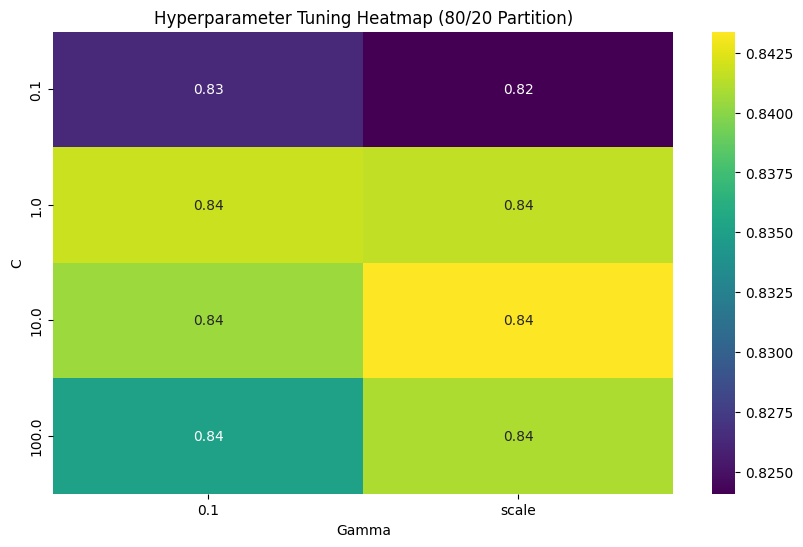

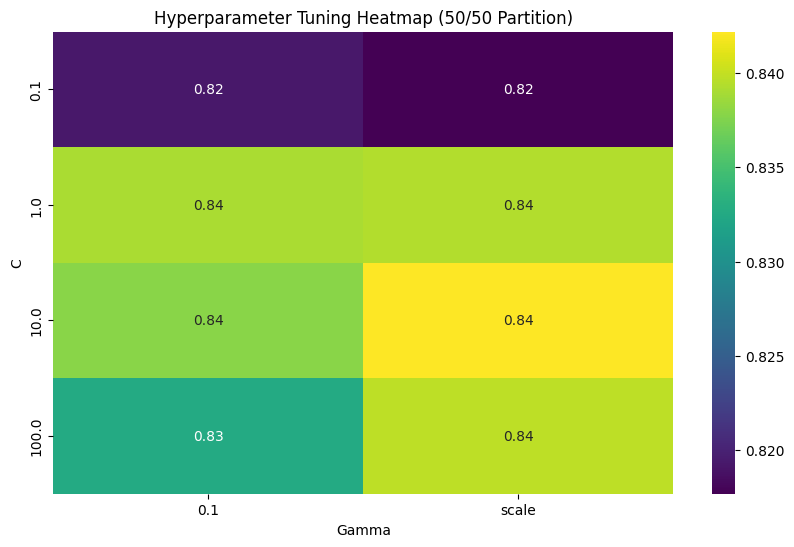

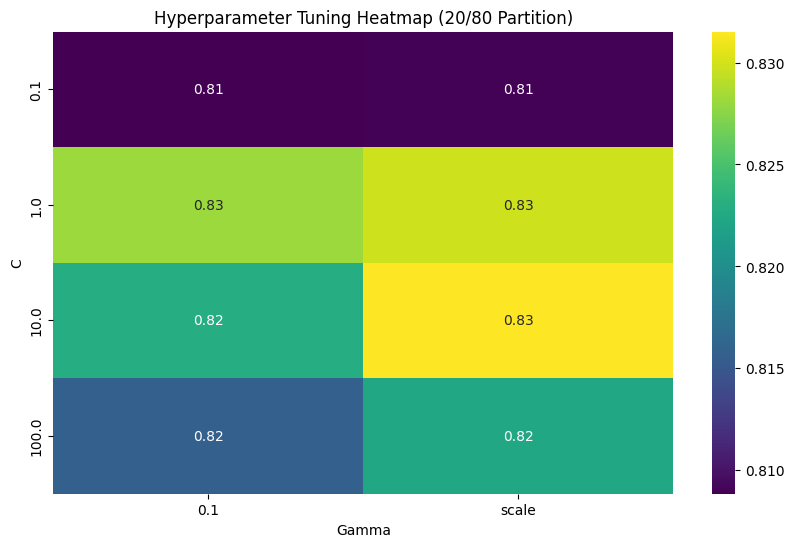


Summary of Results (Averaged Across Rounds):
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.832670       0.837560
1     50/50     0.842185       0.844727
2     80/20     0.843383       0.847892

Training and Validation Errors During Cross-Validation:
Partition: 80/20, Run: 1
Training Scores:
param_gamma       0.1     scale
param_C                        
0.1          0.829894  0.826775
1.0          0.856169  0.848792
10.0         0.869265  0.859122
100.0        0.879678  0.867348
Validation Scores:
param_gamma       0.1     scale
param_C                        
0.1          0.826682  0.824320
1.0          0.841809  0.841602
10.0         0.840151  0.843964
100.0        0.835882  0.840814
Partition: 80/20, Run: 2
Training Scores:
param_gamma       0.1     scale
param_C                        
0.1          0.829925  0.824765
1.0          0.856159  0.848813
10.0         0.869711  0.858624
100.0        0.880155  0.867835
Validation Scores:
param_gamma       0.1     scale
param_C

Partitions:   0%|          | 0/3 [00:00<?, ?it/s]

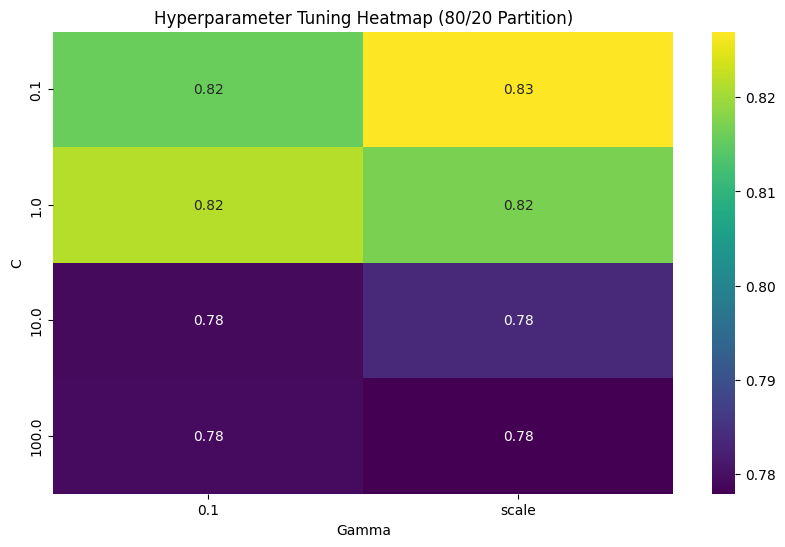

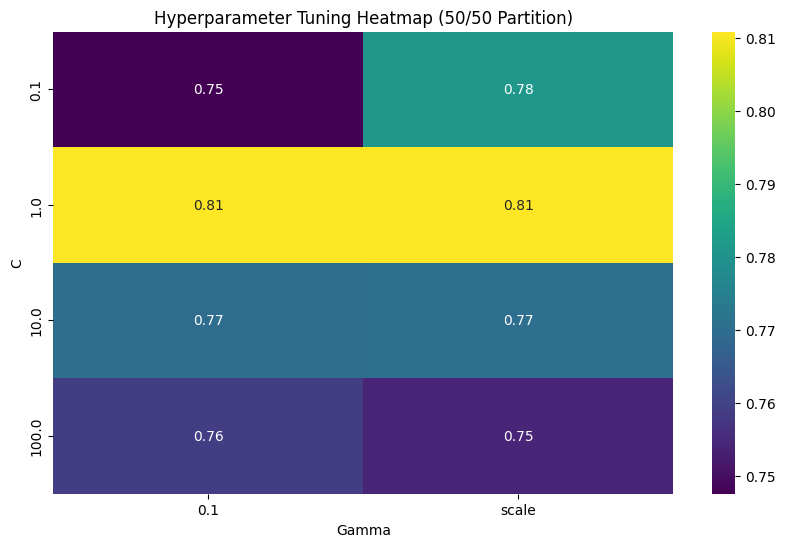

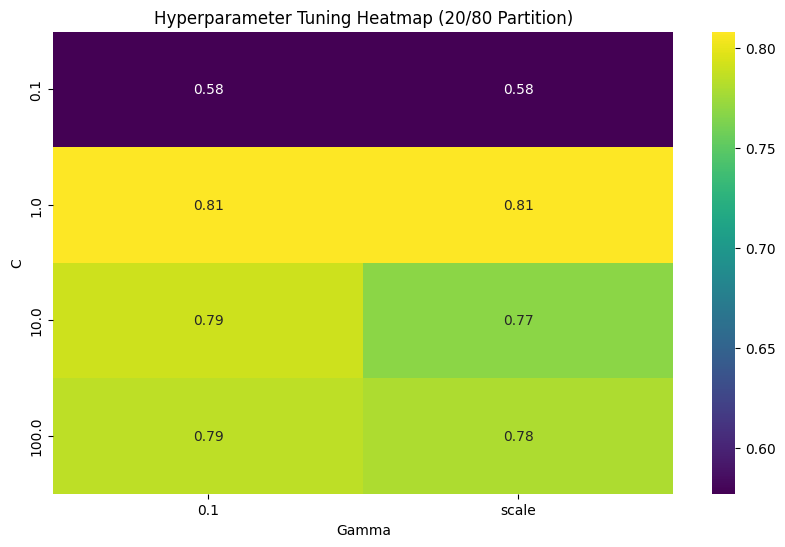


Summary of Results (Averaged Across Rounds):
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.813636       0.810924
1     50/50     0.817548       0.823266
2     80/20     0.833954       0.822222

Training and Validation Errors During Cross-Validation:
Partition: 80/20, Run: 1
Training Scores:
param_gamma       0.1     scale
param_C                        
0.1          0.842840  0.850226
1.0          0.925129  0.907196
10.0         0.993673  0.988399
100.0        1.000000  1.000000
Validation Scores:
param_gamma       0.1     scale
param_C                        
0.1          0.810106  0.827128
1.0          0.810372  0.801862
10.0         0.755585  0.780762
100.0        0.772606  0.772606
Partition: 80/20, Run: 2
Training Scores:
param_gamma       0.1     scale
param_C                        
0.1          0.864979  0.861816
1.0          0.924043  0.906110
10.0         0.997895  0.991562
100.0        1.000000  1.000000
Validation Scores:
param_gamma       0.1     scale
param_C

Partitions:   0%|          | 0/3 [00:00<?, ?it/s]

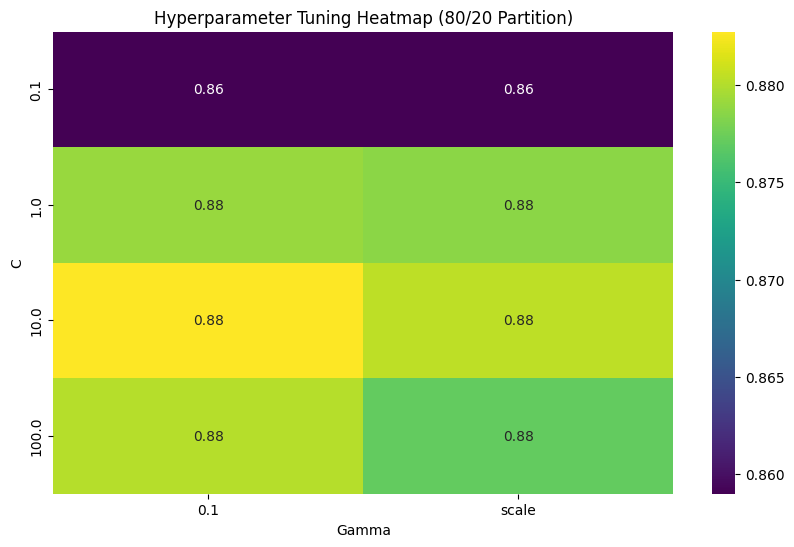

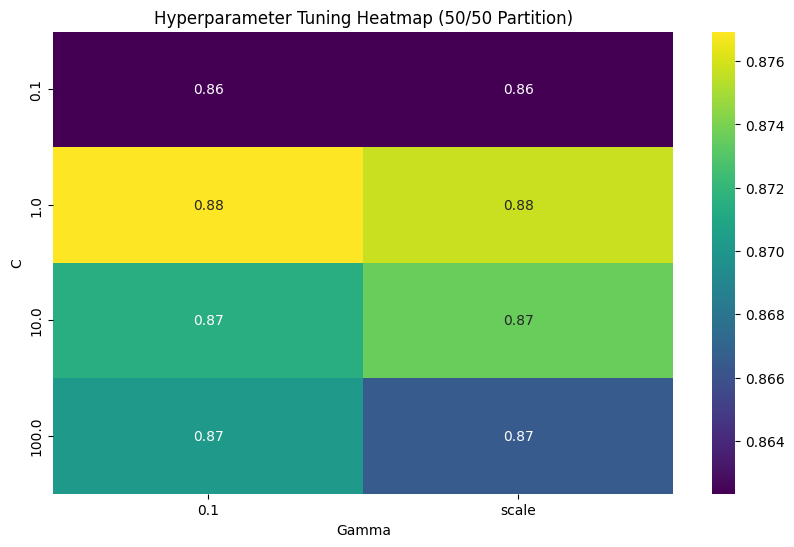

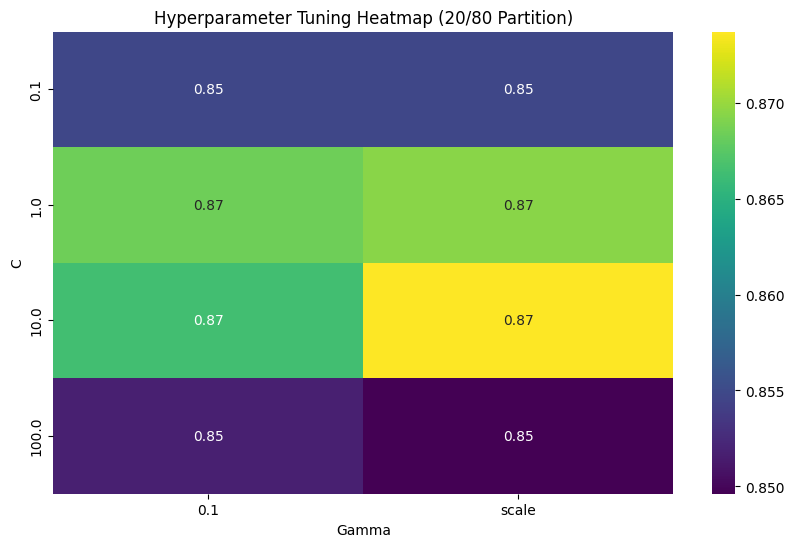


Summary of Results (Averaged Across Rounds):
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.873694       0.869792
1     50/50     0.879830       0.880000
2     80/20     0.884025       0.907292

Training and Validation Errors During Cross-Validation:
Partition: 80/20, Run: 1
Training Scores:
param_gamma       0.1     scale
param_C                        
0.1          0.855356  0.855356
1.0          0.900705  0.898360
10.0         0.952697  0.948788
100.0        0.990227  0.986318
Validation Scores:
param_gamma       0.1     scale
param_C                        
0.1          0.855355  0.855355
1.0          0.878830  0.878051
10.0         0.881180  0.881180
100.0        0.884301  0.880395
Partition: 80/20, Run: 2
Training Scores:
param_gamma       0.1     scale
param_C                        
0.1          0.862393  0.862393
1.0          0.900705  0.898945
10.0         0.949178  0.946637
100.0        0.990032  0.987491
Validation Scores:
param_gamma       0.1     scale
param_C

Partitions:   0%|          | 0/3 [00:00<?, ?it/s]

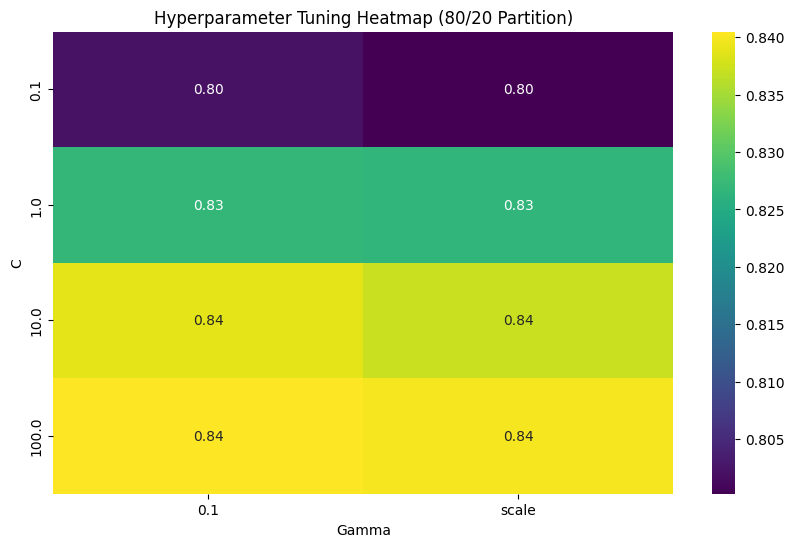

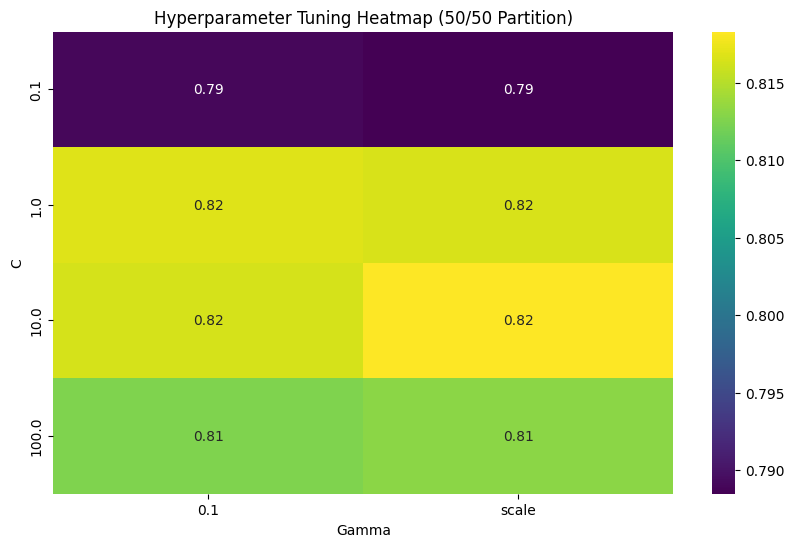

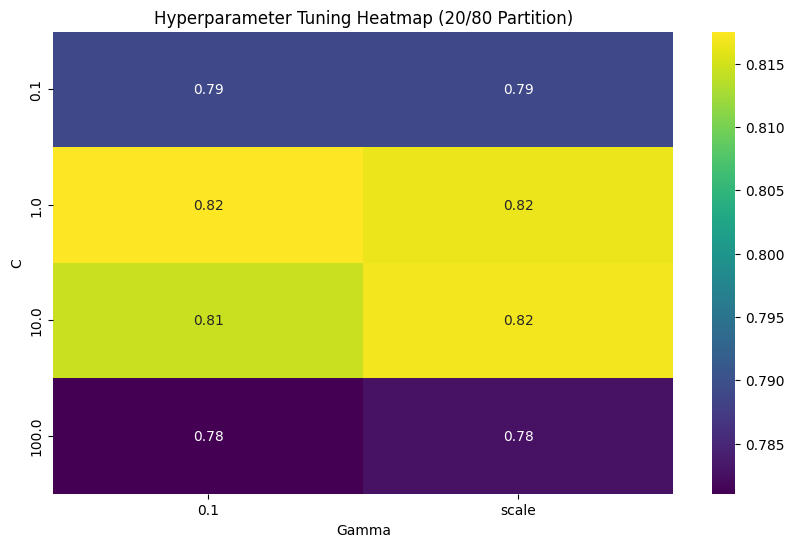


Summary of Results (Averaged Across Rounds):
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.819217       0.812112
1     50/50     0.819387       0.829726
2     80/20     0.842095       0.831293

Training and Validation Errors During Cross-Validation:
Partition: 80/20, Run: 1
Training Scores:
param_gamma       0.1     scale
param_C                        
0.1          0.802769  0.801493
1.0          0.843670  0.842330
10.0         0.894270  0.886932
100.0        0.956866  0.949209
Validation Scores:
param_gamma       0.1     scale
param_C                        
0.1          0.797344  0.796069
1.0          0.826437  0.826181
10.0         0.840480  0.836906
100.0        0.839712  0.840223
Partition: 80/20, Run: 2
Training Scores:
param_gamma       0.1     scale
param_C                        
0.1          0.806789  0.806279
1.0          0.845138  0.843032
10.0         0.890250  0.883422
100.0        0.955845  0.947741
Validation Scores:
param_gamma       0.1     scale
param_C

Partitions:   0%|          | 0/3 [00:00<?, ?it/s]

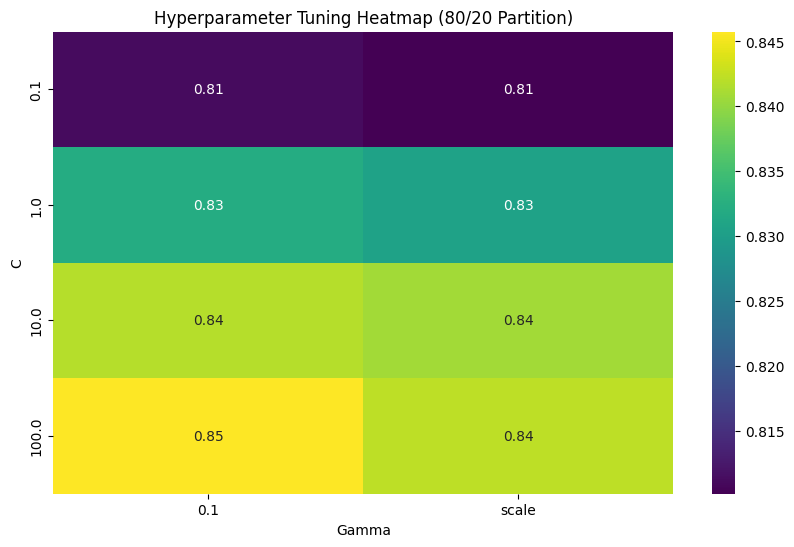

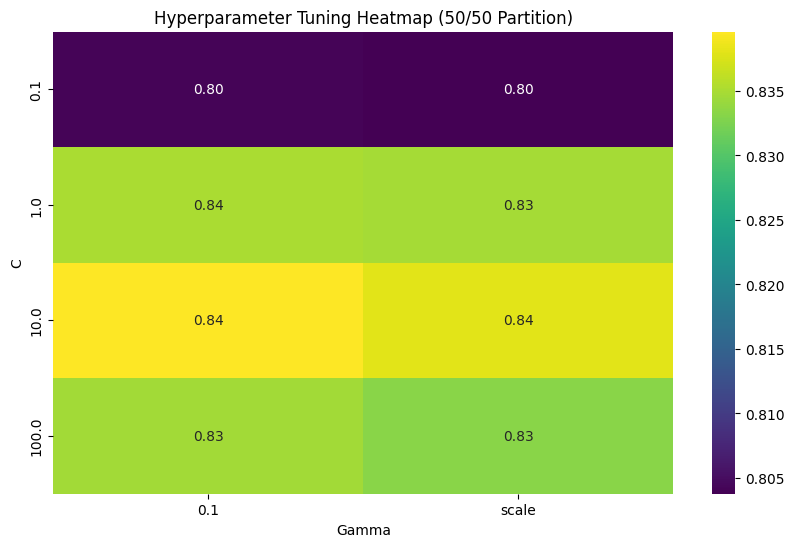

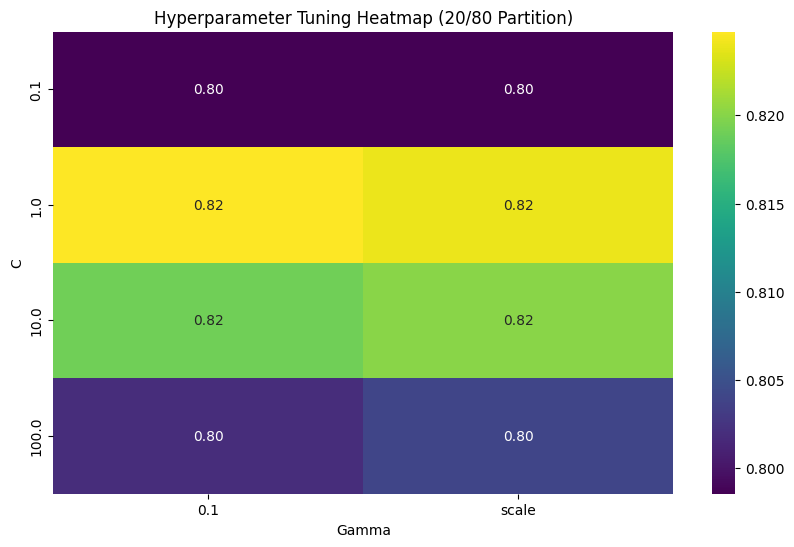


Summary of Results (Averaged Across Rounds):
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.825250       0.827177
1     50/50     0.839903       0.836668
2     80/20     0.845747       0.858718

Training and Validation Errors During Cross-Validation:
Partition: 80/20, Run: 1
Training Scores:
param_gamma       0.1     scale
param_C                        
0.1          0.816818  0.814172
1.0          0.846258  0.843708
10.0         0.885319  0.880797
100.0        0.938955  0.930585
Validation Scores:
param_gamma       0.1     scale
param_C                        
0.1          0.814894  0.813355
1.0          0.834137  0.832597
10.0         0.847222  0.846259
100.0        0.849725  0.847030
Partition: 80/20, Run: 2
Training Scores:
param_gamma       0.1     scale
param_C                        
0.1          0.813835  0.813642
1.0          0.846258  0.843564
10.0         0.882336  0.878343
100.0        0.933952  0.925534
Validation Scores:
param_gamma       0.1     scale
param_C

In [14]:
run_model(svm, datasets)

### Running random forest

Datasets:   0%|          | 0/5 [00:00<?, ?it/s]


Training on 'Adult Dataset' with target column 'salary'...


Partitions:   0%|          | 0/3 [00:00<?, ?it/s]

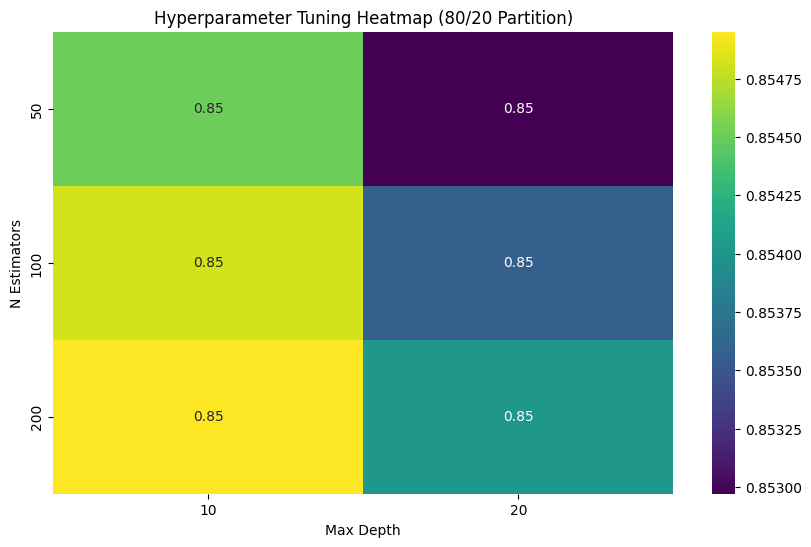

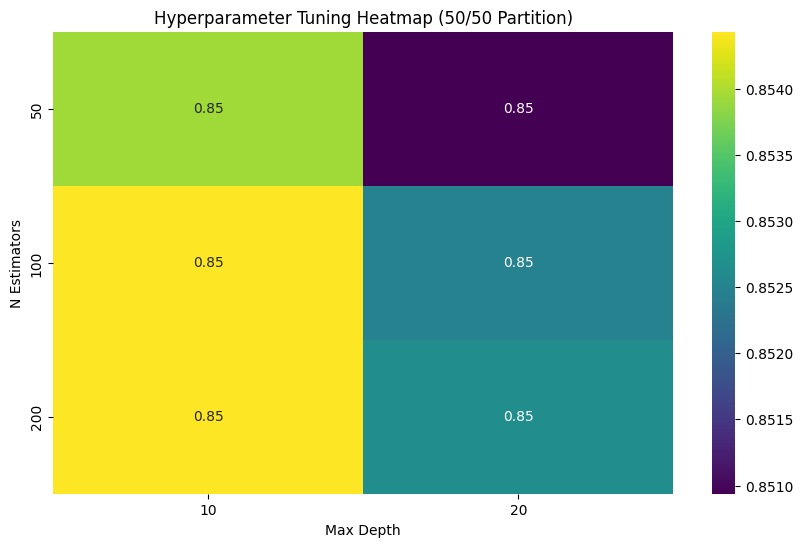

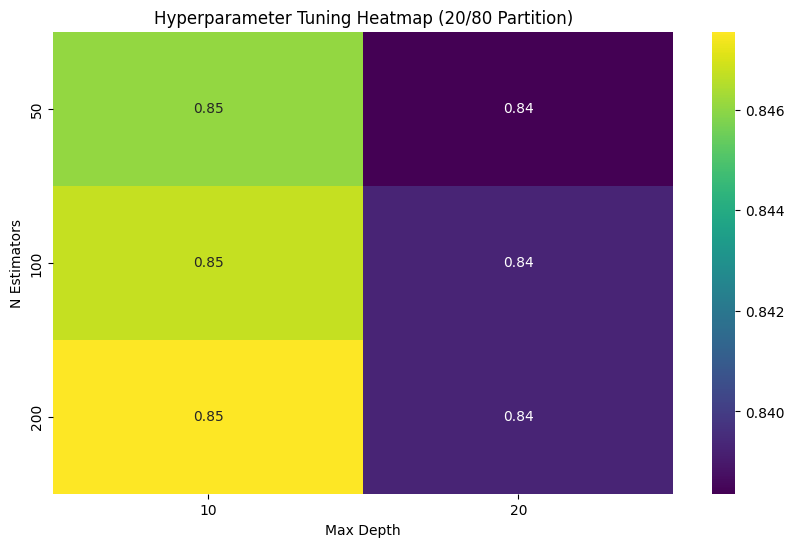


Summary of Results (Averaged Across Rounds):
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.848364       0.852535
1     50/50     0.855911       0.854873
2     80/20     0.856107       0.858279

Training and Validation Errors During Cross-Validation:
Partition: 80/20, Run: 1
Training Scores:
param_max_depth           10        20
param_n_estimators                    
50                  0.860196  0.901277
100                 0.860496  0.901515
200                 0.860576  0.901771
Validation Scores:
param_max_depth           10        20
param_n_estimators                    
50                  0.854546  0.854007
100                 0.854587  0.854573
200                 0.854725  0.854629
Partition: 80/20, Run: 2
Training Scores:
param_max_depth           10        20
param_n_estimators                    
50                  0.861726  0.902044
100                 0.861608  0.902393
200                 0.861356  0.902375
Validation Scores:
param_max_depth           10  

Partitions:   0%|          | 0/3 [00:00<?, ?it/s]

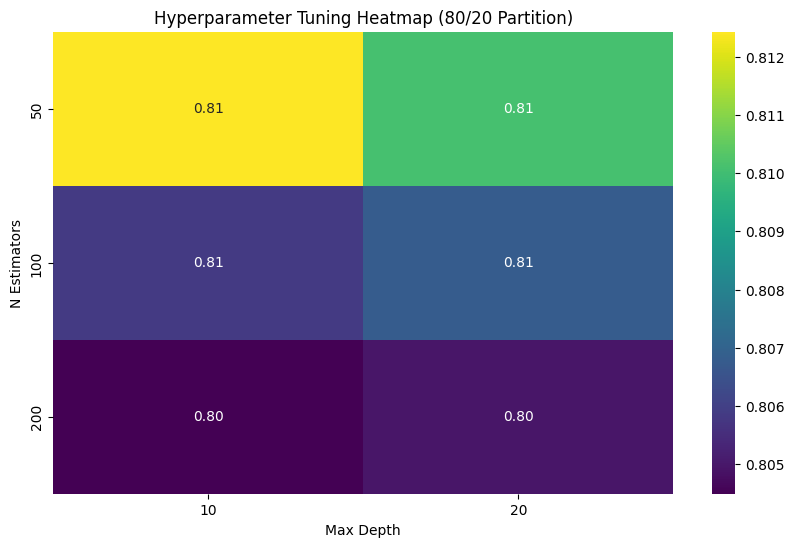

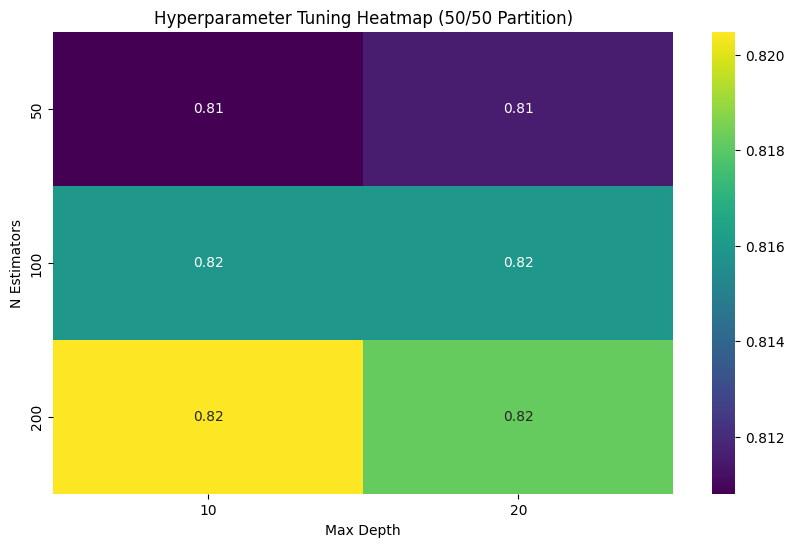

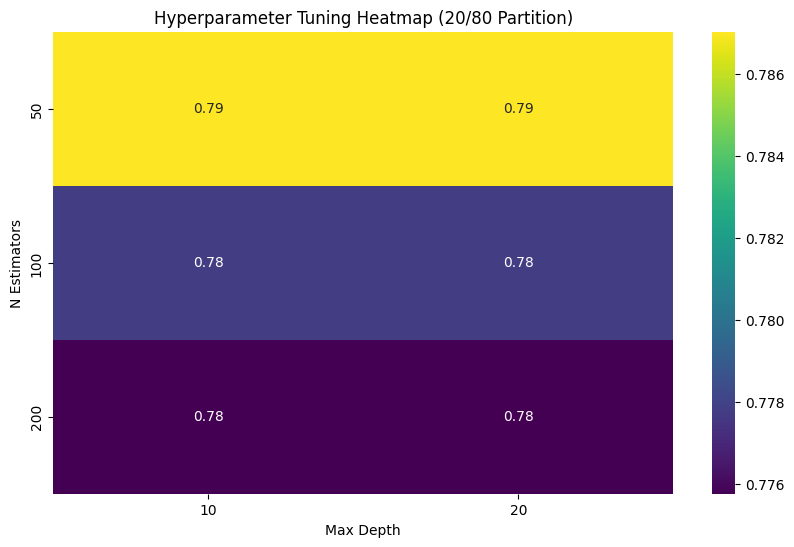


Summary of Results (Averaged Across Rounds):
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.808081       0.801120
1     50/50     0.826513       0.829978
2     80/20     0.821336       0.861111

Training and Validation Errors During Cross-Validation:
Partition: 80/20, Run: 1
Training Scores:
param_max_depth           10        20
param_n_estimators                    
50                  0.979963  0.979963
100                 0.981017  0.981017
200                 0.979961  0.979961
Validation Scores:
param_max_depth           10        20
param_n_estimators                    
50                  0.808983  0.804758
100                 0.801980  0.801980
200                 0.803428  0.803398
Partition: 80/20, Run: 2
Training Scores:
param_max_depth           10        20
param_n_estimators                    
50                  0.974336  0.975041
100                 0.976447  0.976447
200                 0.976094  0.976094
Validation Scores:
param_max_depth           10  

Partitions:   0%|          | 0/3 [00:00<?, ?it/s]

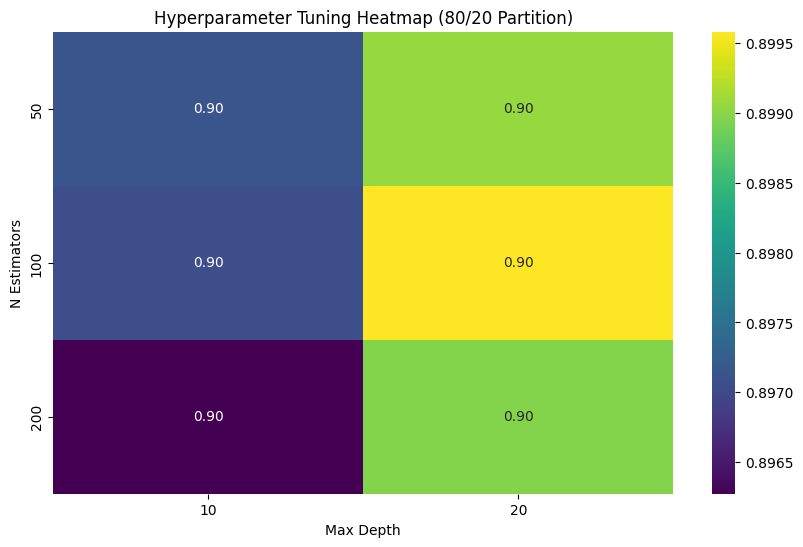

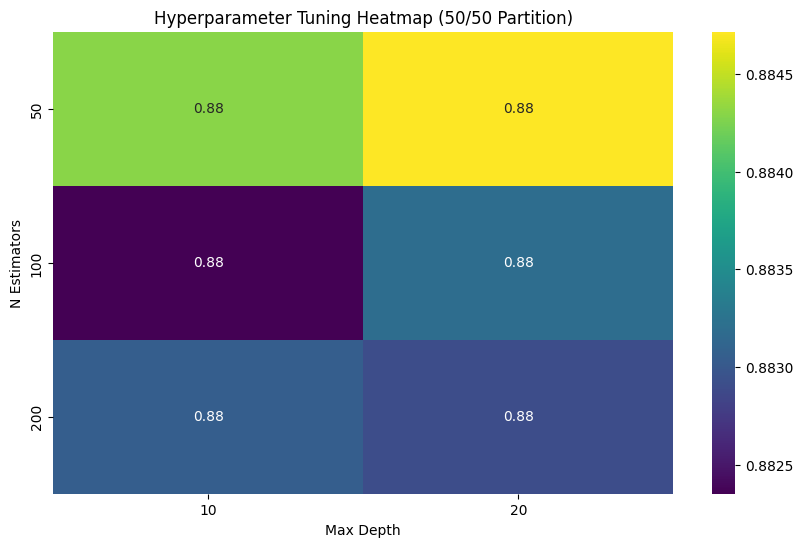

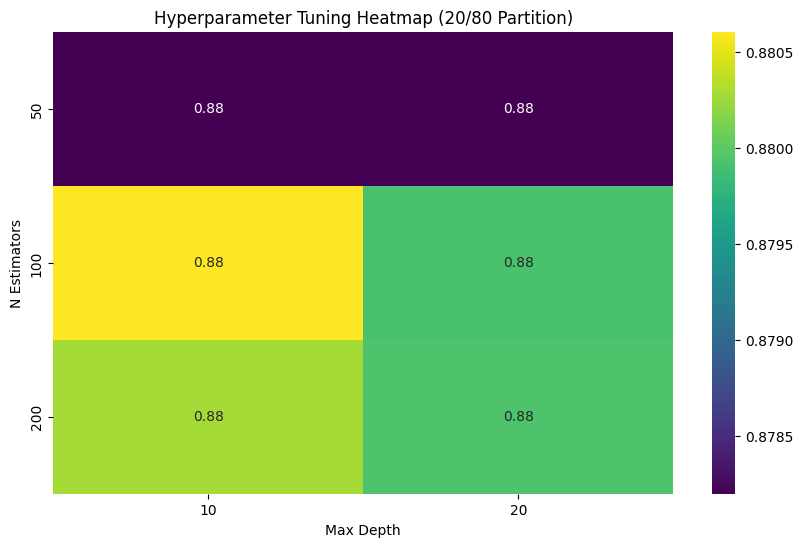


Summary of Results (Averaged Across Rounds):
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.885152       0.882031
1     50/50     0.889452       0.905000
2     80/20     0.908524       0.929167

Training and Validation Errors During Cross-Validation:
Partition: 80/20, Run: 1
Training Scores:
param_max_depth           10        20
param_n_estimators                    
50                  0.982604  0.987881
100                 0.984233  0.988793
200                 0.984689  0.988468
Validation Scores:
param_max_depth           10        20
param_n_estimators                    
50                  0.901500  0.903324
100                 0.899677  0.904109
200                 0.900460  0.903590
Partition: 80/20, Run: 2
Training Scores:
param_max_depth           10        20
param_n_estimators                    
50                  0.983060  0.987100
100                 0.983972  0.987816
200                 0.983711  0.988077
Validation Scores:
param_max_depth           10  

Partitions:   0%|          | 0/3 [00:00<?, ?it/s]

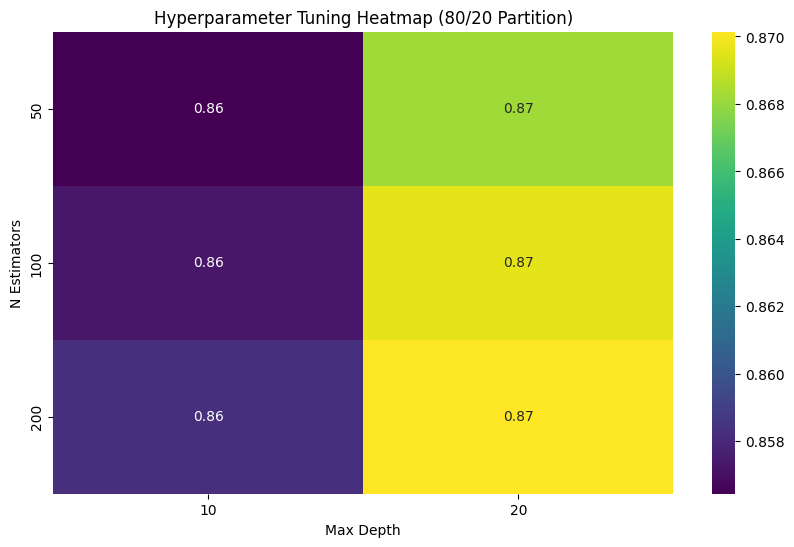

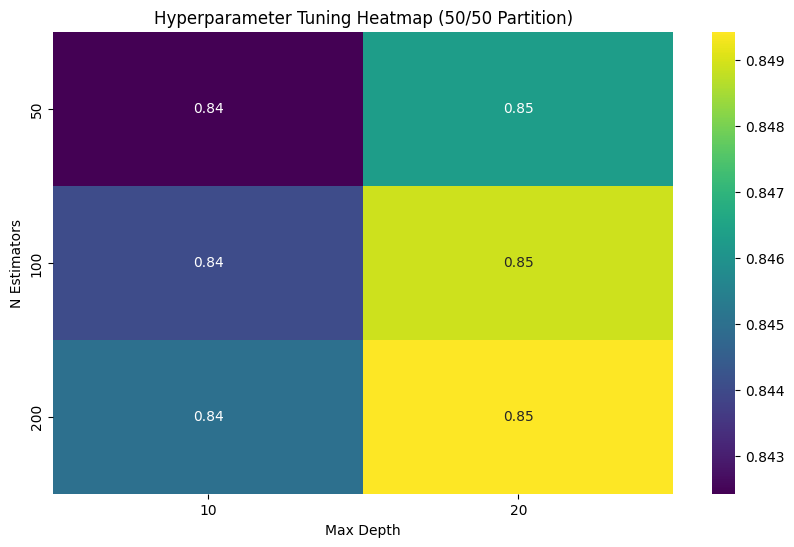

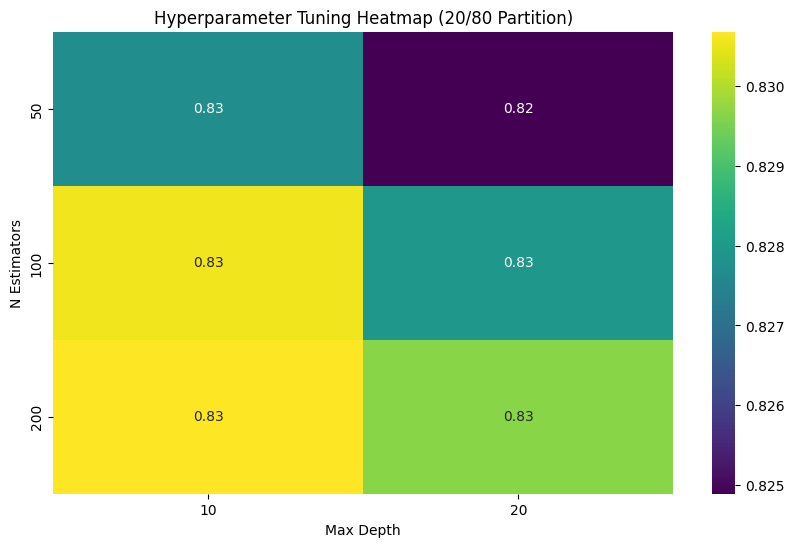


Summary of Results (Averaged Across Rounds):
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.835897       0.832951
1     50/50     0.854365       0.865251
2     80/20     0.874934       0.882313

Training and Validation Errors During Cross-Validation:
Partition: 80/20, Run: 1
Training Scores:
param_max_depth           10        20
param_n_estimators                    
50                  0.952846  0.987302
100                 0.954058  0.988834
200                 0.954420  0.989514
Validation Scores:
param_max_depth           10        20
param_n_estimators                    
50                  0.859106  0.869827
100                 0.859021  0.870677
200                 0.860041  0.870847
Partition: 80/20, Run: 2
Training Scores:
param_max_depth           10        20
param_n_estimators                    
50                  0.955228  0.988089
100                 0.957227  0.989089
200                 0.956759  0.989472
Validation Scores:
param_max_depth           10  

Partitions:   0%|          | 0/3 [00:00<?, ?it/s]

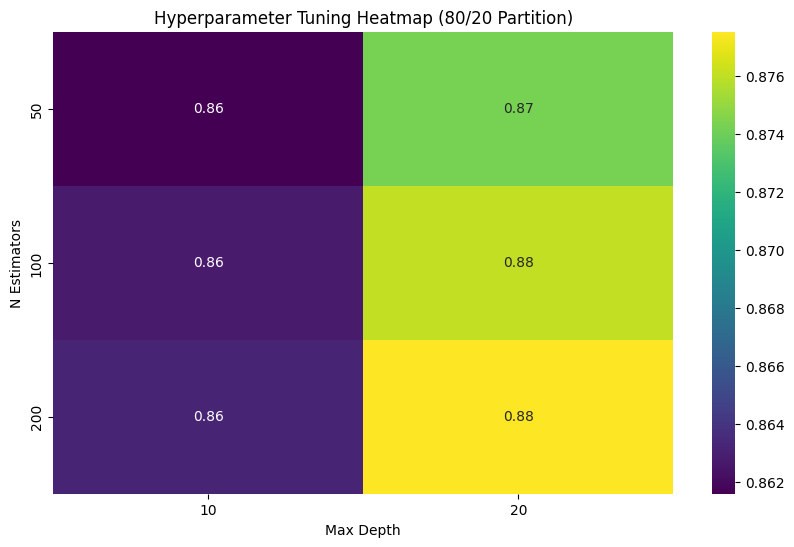

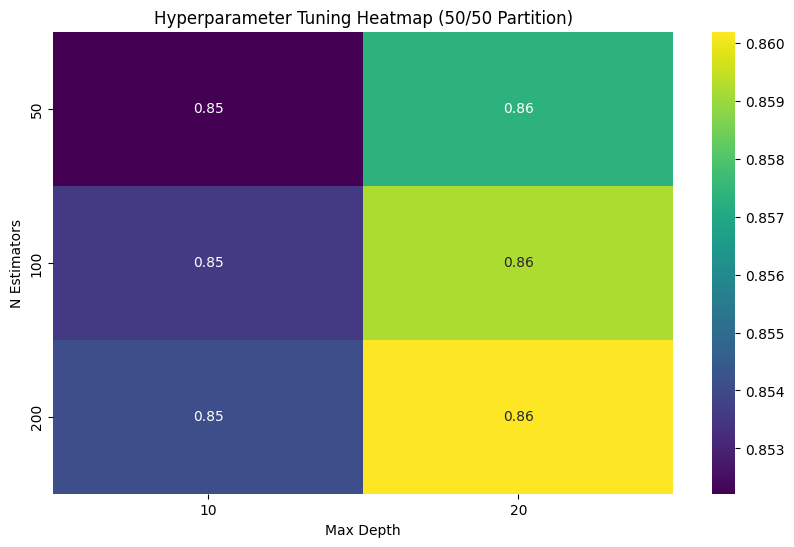

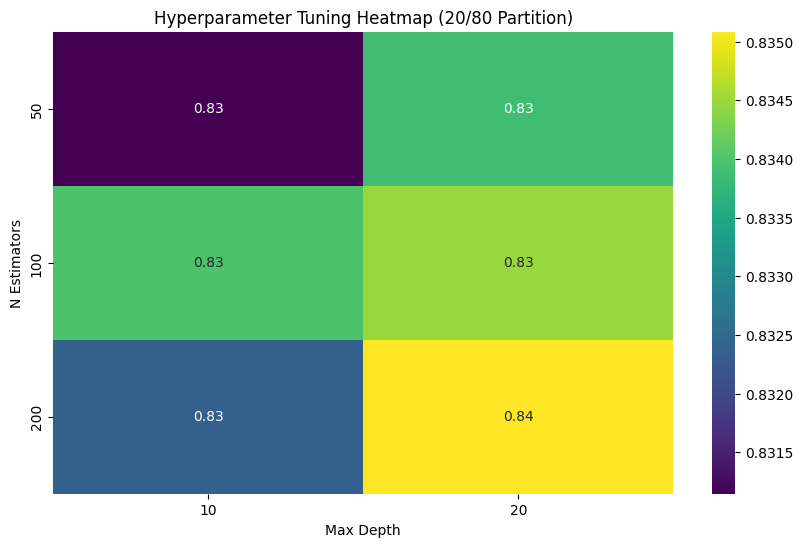


Summary of Results (Averaged Across Rounds):
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.842694       0.844940
1     50/50     0.865048       0.873602
2     80/20     0.881854       0.898974

Training and Validation Errors During Cross-Validation:
Partition: 80/20, Run: 1
Training Scores:
param_max_depth           10        20
param_n_estimators                    
50                  0.945017  0.987012
100                 0.945898  0.988150
200                 0.946941  0.988936
Validation Scores:
param_max_depth           10        20
param_n_estimators                    
50                  0.866655  0.877045
100                 0.867360  0.880637
200                 0.866655  0.881279
Partition: 80/20, Run: 2
Training Scores:
param_max_depth           10        20
param_n_estimators                    
50                  0.942948  0.986803
100                 0.944936  0.988086
200                 0.944856  0.988663
Validation Scores:
param_max_depth           10  

In [15]:
run_model(random_forest, datasets)

### Running logistic regression 

Datasets:   0%|          | 0/5 [00:00<?, ?it/s]


Training on 'Adult Dataset' with target column 'salary'...


Partitions:   0%|          | 0/3 [00:00<?, ?it/s]

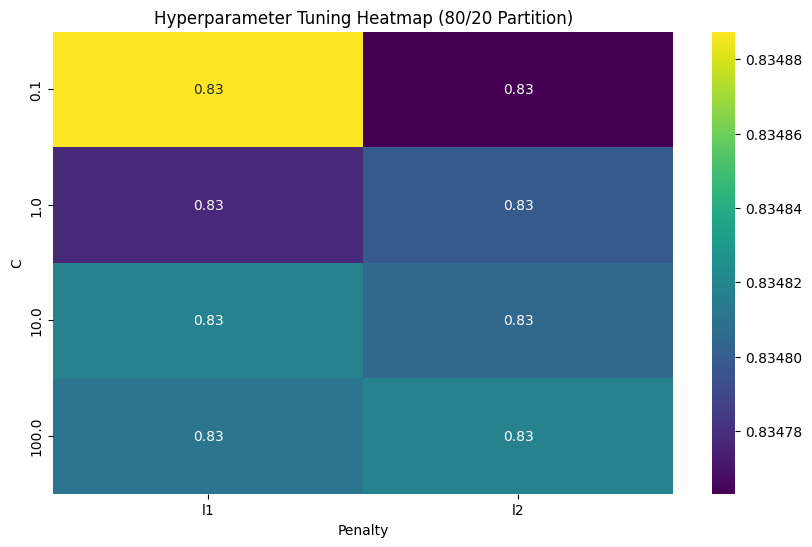

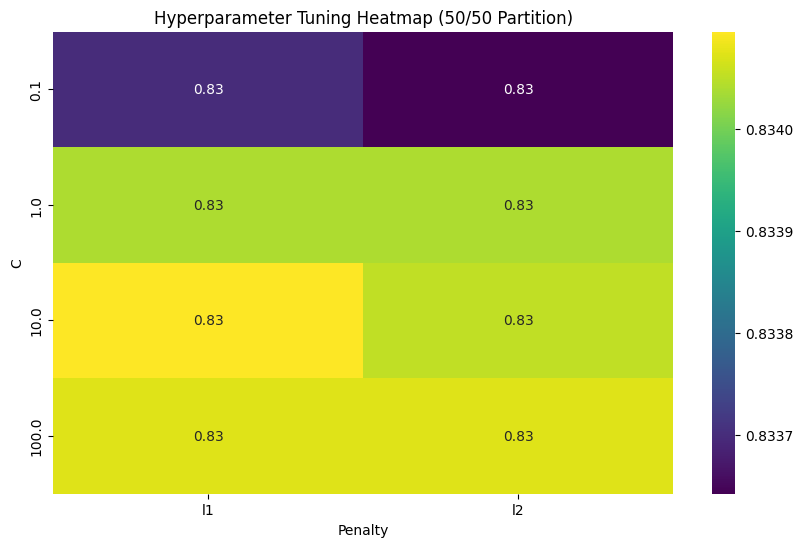

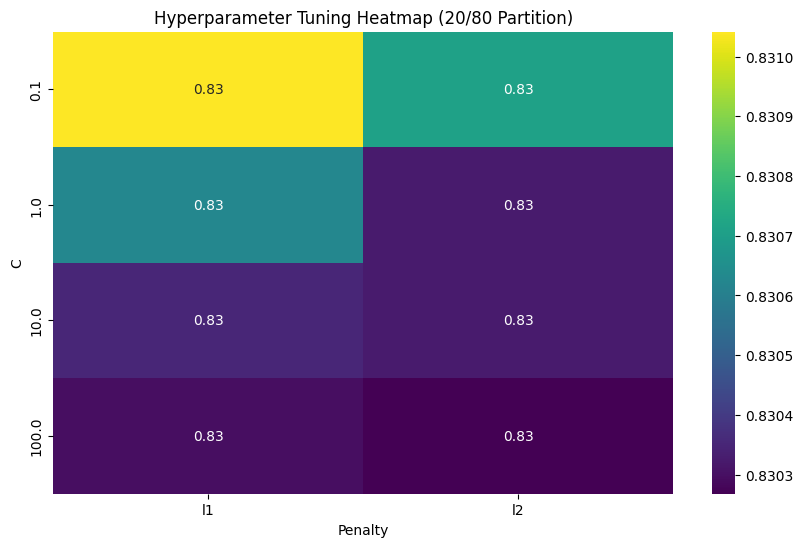


Summary of Results (Averaged Across Rounds):
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.831456       0.834922
1     50/50     0.834228       0.835577
2     80/20     0.834957       0.836068

Training and Validation Errors During Cross-Validation:
Partition: 80/20, Run: 1
Training Scores:
param_penalty        l1        l2
param_C                          
0.1            0.835001  0.834976
1.0            0.835017  0.834996
10.0           0.835027  0.835053
100.0          0.835043  0.835048
Validation Scores:
param_penalty        l1        l2
param_C                          
0.1            0.835032  0.834887
1.0            0.835136  0.835136
10.0           0.835136  0.835136
100.0          0.835136  0.835136
Partition: 80/20, Run: 2
Training Scores:
param_penalty        l1        l2
param_C                          
0.1            0.834742  0.834644
1.0            0.834654  0.834691
10.0           0.834649  0.834649
100.0          0.834644  0.834654
Validation Scores:
par

Partitions:   0%|          | 0/3 [00:00<?, ?it/s]

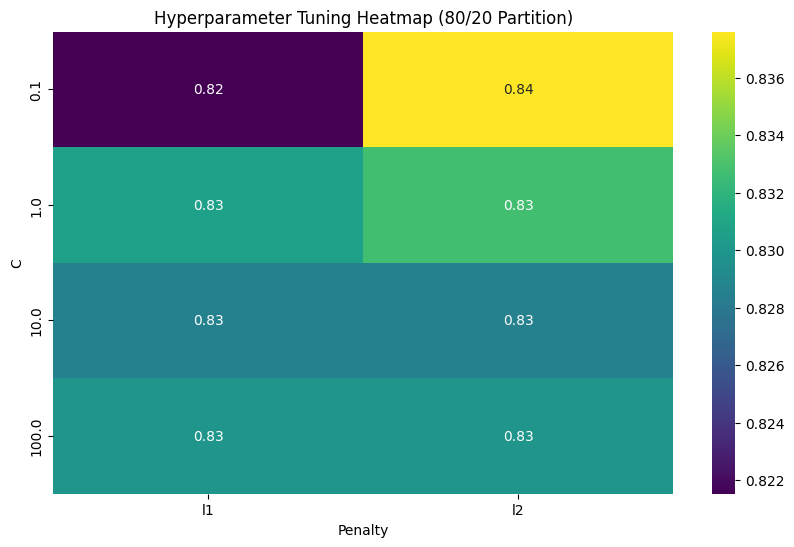

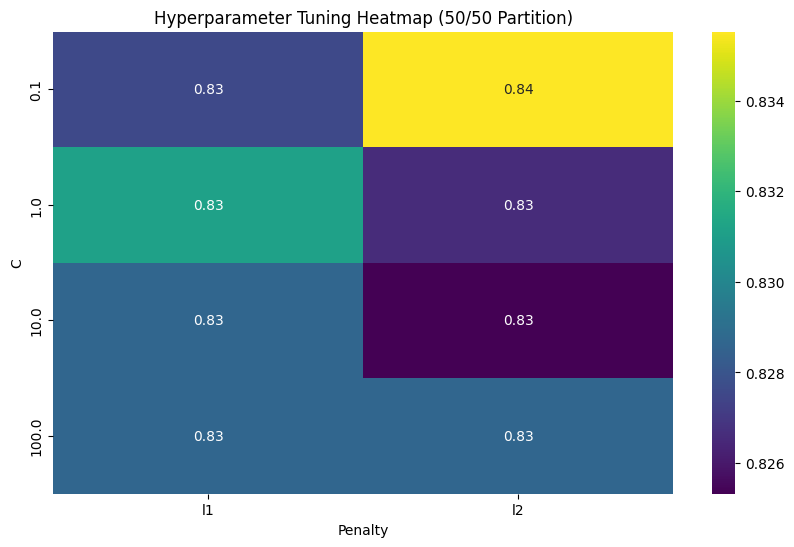

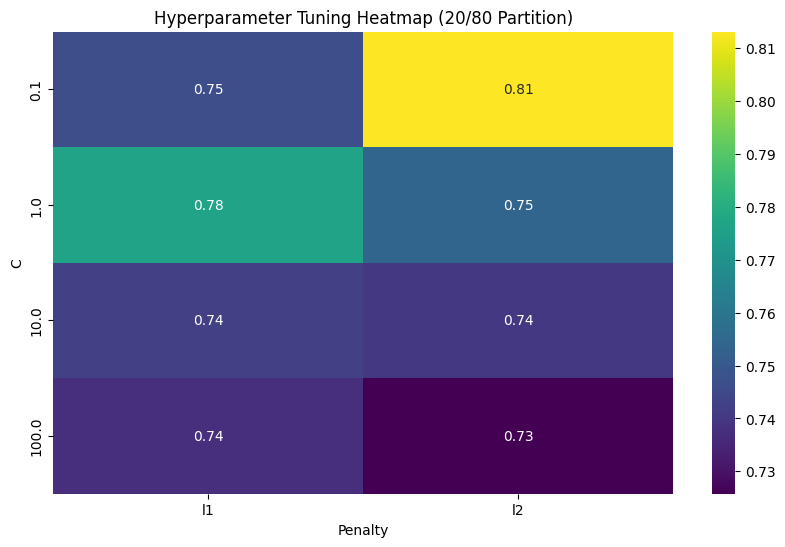


Summary of Results (Averaged Across Rounds):
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.824242       0.834734
1     50/50     0.844521       0.825503
2     80/20     0.838327       0.833333

Training and Validation Errors During Cross-Validation:
Partition: 80/20, Run: 1
Training Scores:
param_penalty        l1        l2
param_C                          
0.1            0.843893  0.857605
1.0            0.861838  0.862370
10.0           0.858680  0.858680
100.0          0.857622  0.857622
Validation Scores:
param_penalty        l1        l2
param_C                          
0.1            0.814628  0.837899
1.0            0.831560  0.831560
10.0           0.827394  0.827394
100.0          0.827394  0.827394
Partition: 80/20, Run: 2
Training Scores:
param_penalty        l1        l2
param_C                          
0.1            0.840189  0.858118
1.0            0.858635  0.857583
10.0           0.862868  0.861816
100.0          0.861816  0.861816
Validation Scores:
par

Partitions:   0%|          | 0/3 [00:00<?, ?it/s]

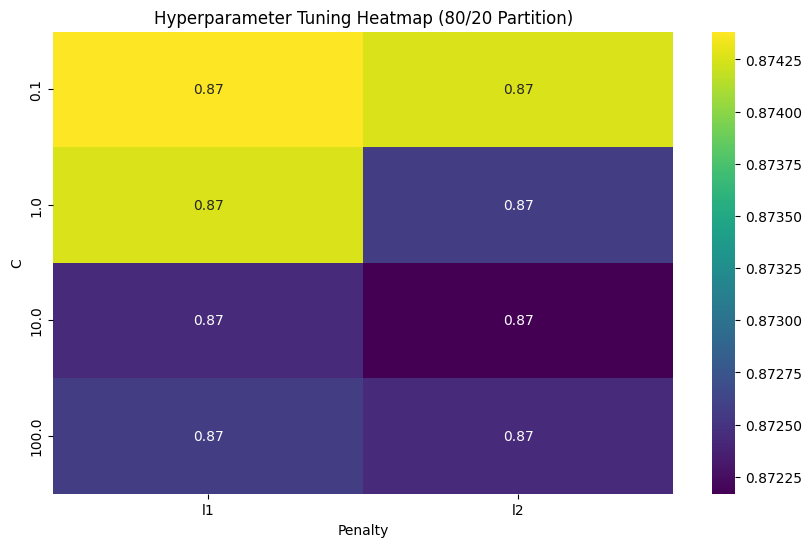

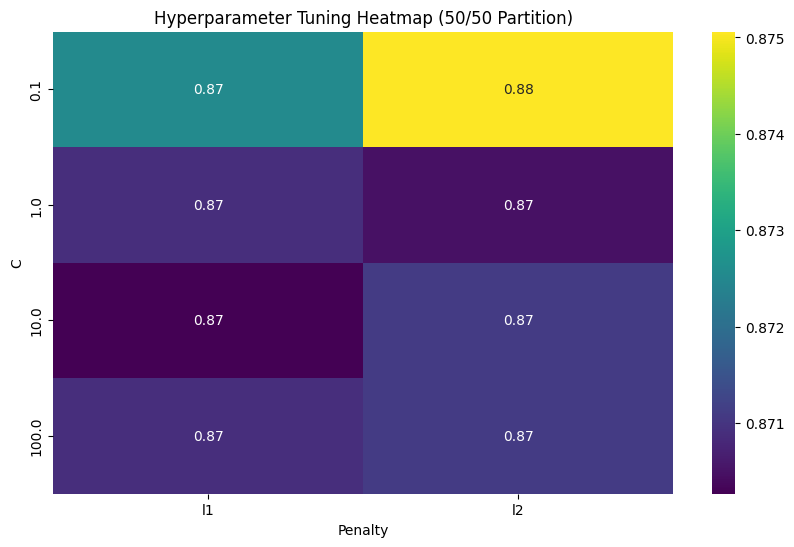

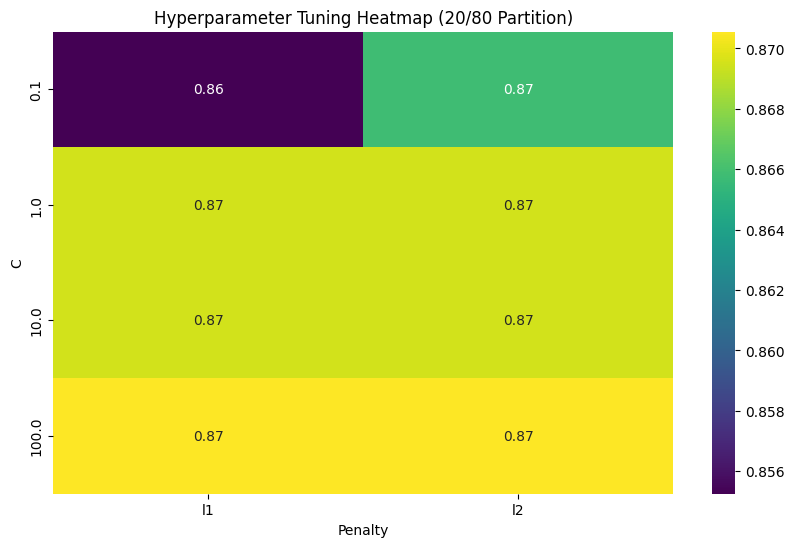


Summary of Results (Averaged Across Rounds):
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.872619       0.872135
1     50/50     0.877353       0.882083
2     80/20     0.876990       0.891667

Training and Validation Errors During Cross-Validation:
Partition: 80/20, Run: 1
Training Scores:
param_penalty        l1        l2
param_C                          
0.1            0.874610  0.878226
1.0            0.880962  0.880572
10.0           0.879985  0.880181
100.0          0.879985  0.879985
Validation Scores:
param_penalty        l1        l2
param_C                          
0.1            0.872564  0.871788
1.0            0.877261  0.874916
10.0           0.874914  0.874524
100.0          0.874914  0.874524
Partition: 80/20, Run: 2
Training Scores:
param_penalty        l1        l2
param_C                          
0.1            0.878714  0.879887
1.0            0.879007  0.878323
10.0           0.878616  0.878421
100.0          0.878225  0.878127
Validation Scores:
par

Partitions:   0%|          | 0/3 [00:00<?, ?it/s]

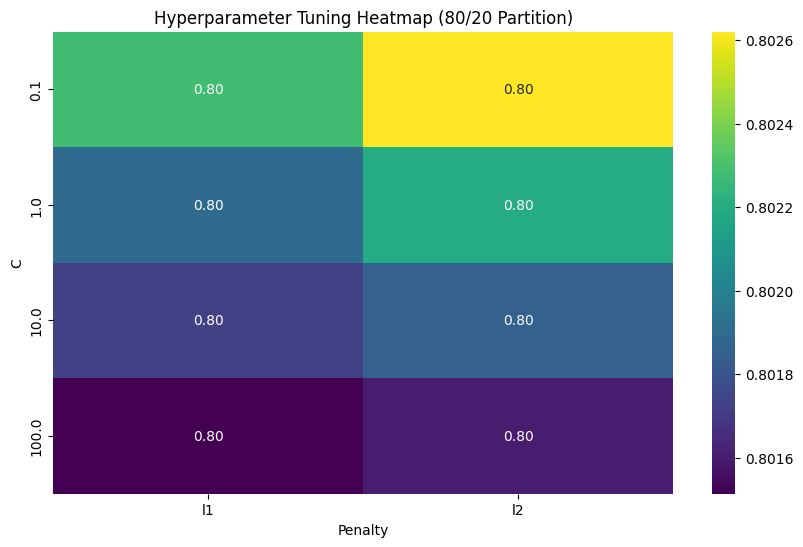

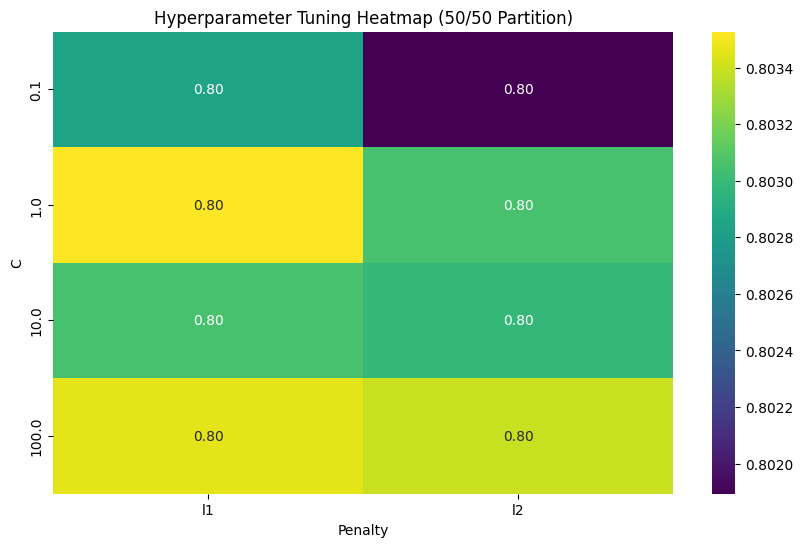

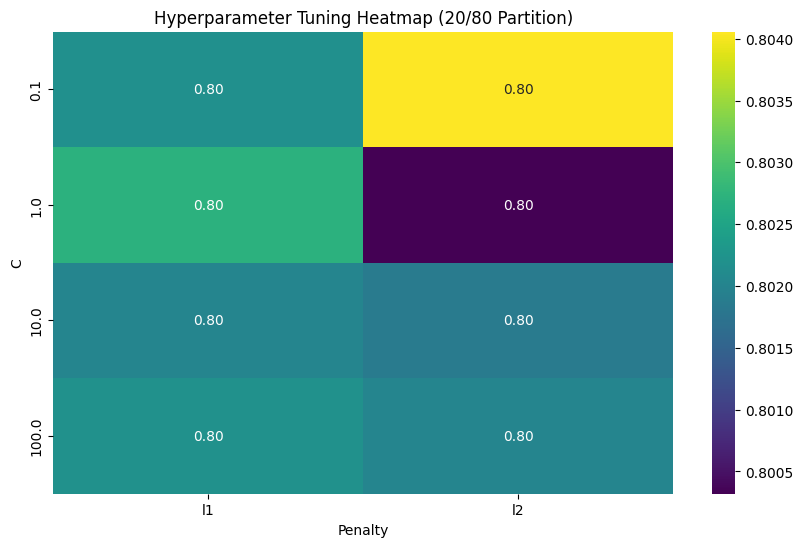


Summary of Results (Averaged Across Rounds):
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.807291       0.801480
1     50/50     0.805228       0.799918
2     80/20     0.803046       0.795578

Training and Validation Errors During Cross-Validation:
Partition: 80/20, Run: 1
Training Scores:
param_penalty        l1        l2
param_C                          
0.1            0.806151  0.806087
1.0            0.804492  0.804301
10.0           0.804970  0.805130
100.0          0.805002  0.804970
Validation Scores:
param_penalty        l1        l2
param_C                          
0.1            0.803849  0.804488
1.0            0.804488  0.804488
10.0           0.803467  0.803467
100.0          0.803212  0.803339
Partition: 80/20, Run: 2
Training Scores:
param_penalty        l1        l2
param_C                          
0.1            0.802673  0.800727
1.0            0.800217  0.799738
10.0           0.799866  0.799898
100.0          0.799770  0.799834
Validation Scores:
par

Partitions:   0%|          | 0/3 [00:00<?, ?it/s]

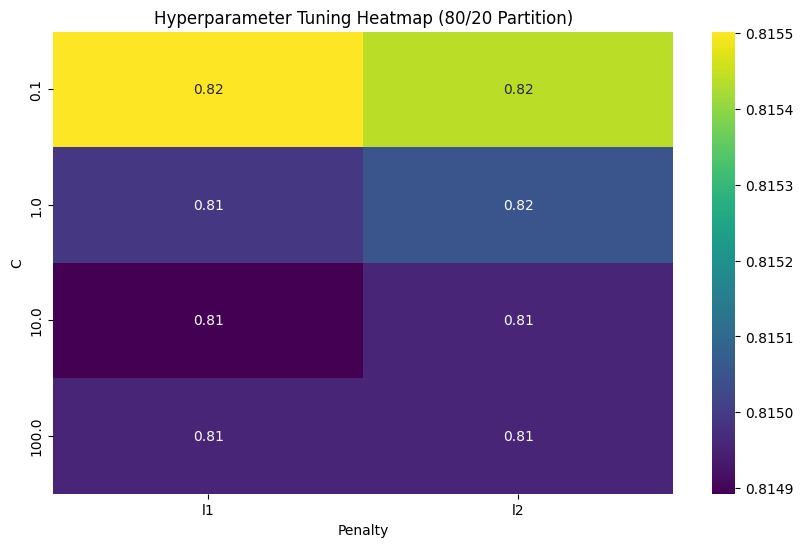

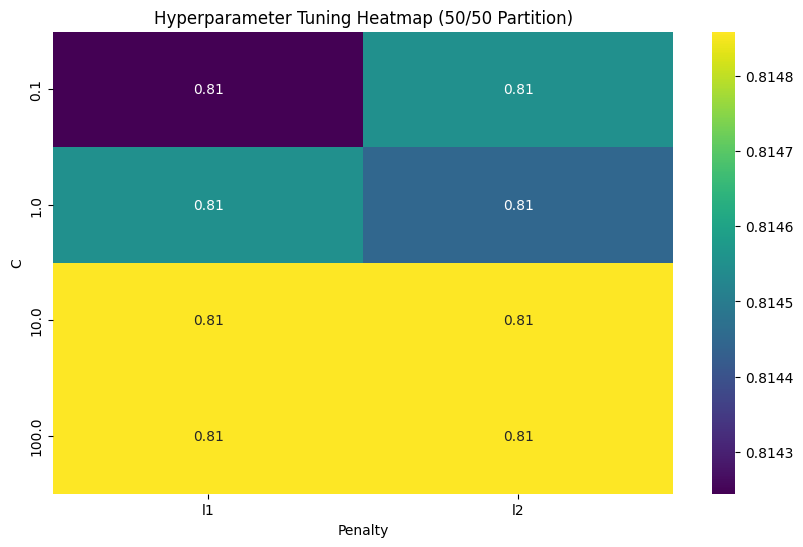

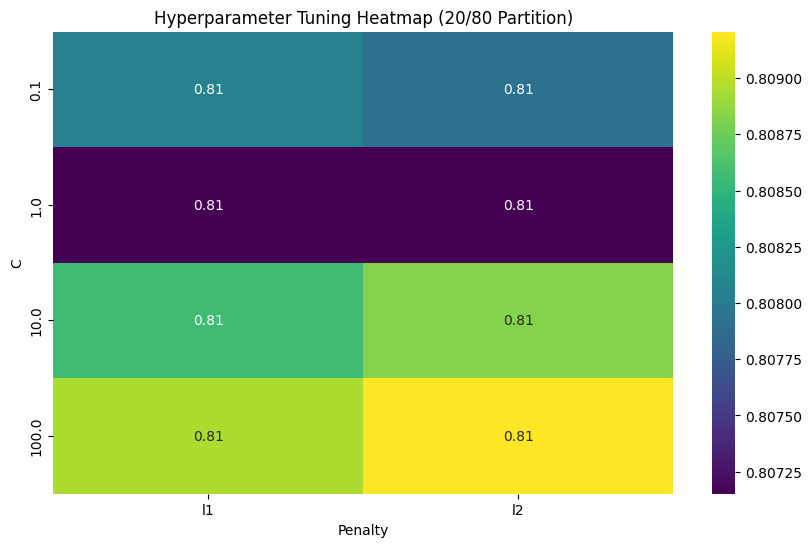


Summary of Results (Averaged Across Rounds):
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.810875       0.815249
1     50/50     0.816193       0.820868
2     80/20     0.815919       0.828462

Training and Validation Errors During Cross-Validation:
Partition: 80/20, Run: 1
Training Scores:
param_penalty        l1        l2
param_C                          
0.1            0.815518  0.816457
1.0            0.816865  0.816673
10.0           0.816721  0.816673
100.0          0.816673  0.816673
Validation Scores:
param_penalty        l1        l2
param_C                          
0.1            0.815278  0.814989
1.0            0.814509  0.814316
10.0           0.814123  0.814123
100.0          0.814123  0.814123
Partition: 80/20, Run: 2
Training Scores:
param_penalty        l1        l2
param_C                          
0.1            0.816288  0.817515
1.0            0.816673  0.816745
10.0           0.816240  0.816408
100.0          0.816384  0.816384
Validation Scores:
par

In [16]:
run_model(logistic_regression, datasets)